In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1D Steady Heat Conduction

In [40]:
# Initialize parameters of the question
k = 50 # Thermal conductivity, W/K
L = 0.1 # m
A = 75e-6 # m^2
cp = 0.1 # Specific heat capacity, J/(kg * K)
rho = 0.1 # kg/m^3
# C = cp*rho # J/K, volume specific

# boundary conditions
T_L = 390 # K, x=0
T_R = 290 # K, x=L


In [43]:
# discretize the space
n_elem = 10
n_nodes = n_elem + 1
l_elem = L/n_elem
dx = l_elem
elem_x = np.linspace(l_elem/2, L-l_elem/2, n_elem)
nodes_x = np.linspace(0, L, n_nodes)
print("Positions of nodes", nodes_x)

n_dof = n_elem # degree of freedom of the system

CON = [] # connectivity
for i in range(n_elem):
    CON.append([i, i+1])
print("Connectivty", CON)

class Element:
    def __init__(self, nodes, x, k, cp, rho, l):
        self.nodes = nodes
        self.x = x
        self.k = k
        self.cp = cp
        self.rho = rho
        self.l = l

    def __repr__(self):
        return f"Element(nodes={self.nodes})"

# create elements
elements = []
for i in range(n_elem):
    x = l_elem*(i+0.5)
    elements.append(Element(CON[i], elem_x[i], k, cp, rho, l_elem))

print("Elements", elements)


# discretize the time
t_final = 1
dt = 0.1
t = np.arange(0, t_final, dt)
print("Time values", t)


Positions of nodes [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]
Connectivty [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10]]
Elements [Element(nodes=[0, 1]), Element(nodes=[1, 2]), Element(nodes=[2, 3]), Element(nodes=[3, 4]), Element(nodes=[4, 5]), Element(nodes=[5, 6]), Element(nodes=[6, 7]), Element(nodes=[7, 8]), Element(nodes=[8, 9]), Element(nodes=[9, 10])]
Time values [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


-77999999999.99998
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-9999999999.999998
1.1699999219999995e+18
-3.899999999999998e+17
0.0
0.0
0.0
0.0
0.0
0.0
-4.9999999999999976e+16
1.4999998999999994e+17
-1.9499997660000066e+25
9.749999219999994e+24
-1.9499999999999985e+24
0.0
0.0
0.0
0.0
-2.4999999999999983e+23
1.2499998999999993e+24
-2.4999997000000087e+24
3.412499415000033e+32
-2.04749970750001e+32
6.824999414999995e+31
-9.749999999999991e+30
0.0
0.0
-1.249999999999999e+30
8.749999249999993e+30
-2.624999625000013e+31
4.374999250000042e+31
-6.142498635000112e+39
4.0949991810000536e+39
-1.75499972700001e+39
4.3874996099999954e+38
-4.874999999999995e+37
-6.249999999999994e+36
5.624999499999994e+37
-2.2499996500000128e+38
5.24999895000007e+38
-7.874998250000144e+38
1.126124692875033e+47
-8.043747952500196e+46
4.0218741225000637e+46
-1.340624780625008e+46
2.6499997562499967e+45
9.999996874999994e+43
-1.7187497187500105e+45
5.1562488750000814e+45
-1.0312497375000251e+46
1.4437496062500424e+46
-2.091374324

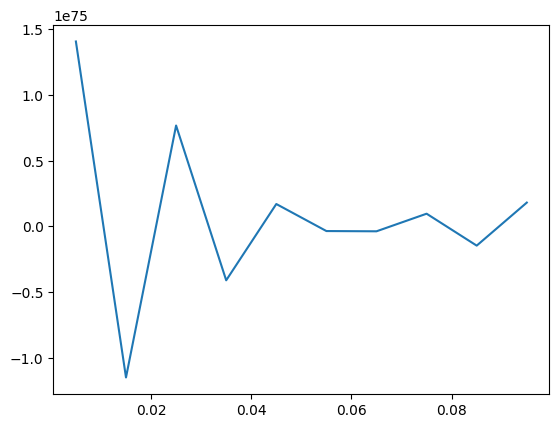

In [44]:
# creating temperature values
T = np.ones(n_dof) * T_L # for two BC
dTdt = np.zeros(n_dof)

for j in range(len(t)):
    for i in range(n_dof):
        element = elements[i]
        alpha = element.k/(element.rho*element.cp)

        if i == 0: # left BC
            dTdt[i] = alpha*(
                (-T[i]-T_L)/(0.5*element.l**2)
                +(T[i+1]-T[i])/element.l**2
                )
        elif i == n_dof-1: # right bC
            dTdt[i] = alpha*(
                (T[i-1]-T[i])/element.l**2
                +(T_R-T[i])/(0.5*element.l**2)
                )
        else:
            dTdt[i] = alpha*(T[i+1]-2*T[i]+T[i-1])/element.l**2
        print(dTdt[i])

    T = T + dTdt*dt


plt.plot(elem_x, T)
plt.show()

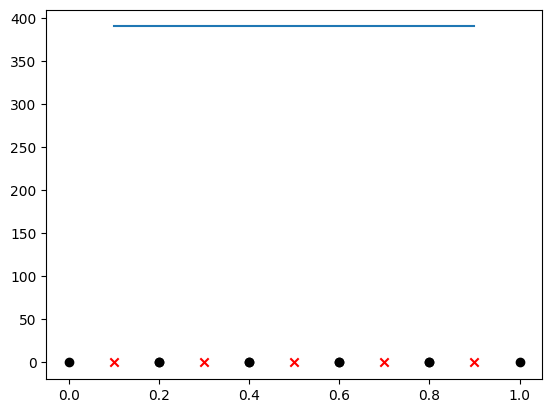

In [18]:
# plot elements and nodes
for i in range(n_elem):
    element = elements[i]
    plt.scatter([element.x], [0], color='red', marker="x")
    node_1 = element.nodes[0]
    node_2 = element.nodes[1]
    x1 = nodes_x[node_1]
    x2 = nodes_x[node_2]
    plt.scatter(x1, 0, color='black', marker="o")
    plt.scatter(x2, 0, color='black', marker="o")

plt.plot(elem_x, T[1:-1])
# plt.legend()
plt.show()